In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import openml
from scipy.stats import wilcoxon
from sklearn.metrics import zero_one_loss
from loess import loess, loess_fast
%matplotlib inline

sns.set_context("paper", font_scale=1.5)   

In [2]:
def bin_data(y, n_bins):
    """
    Partitions the data into ordered bins based on
    the probabilities. Returns the binned indices.
    """
    edges = np.linspace(0, 1, n_bins)
    bin_idx = np.digitize(y, edges, right=True)
    binned_idx = [np.where(bin_idx == i)[0] for i in range(n_bins)]
    
    return binned_idx
    
def bin_stats(y_true, y_proba, bin_idx):
    # mean accuracy within each bin
    bin_acc = [
        np.equal(np.argmax(y_proba[idx], axis=1), y_true[idx]).mean() if len(idx) > 0 else 0
        for idx in bin_idx
    ]
    # mean confidence of prediction within each bin
    bin_conf = [
        np.mean(np.max(y_proba[idx], axis=1)) if len(idx) > 0 else 0
        for idx in bin_idx 
    ]
    
    return np.asarray(bin_acc), np.asarray(bin_conf)

def ece(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    n = len(y_true)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    bin_sizes = [len(idx) for idx in bin_idx]
    
    ece = np.sum(np.abs(bin_acc - bin_conf) * np.asarray(bin_sizes)) / n
    
    return ece

def mce(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    mce = np.max(np.abs(bin_acc - bin_conf))
    
    return mce

def brier_score_mvloss(y_true, y_proba):
    if y_true.ndim == 1:
        y_true = np.squeeze(np.eye(len(np.unique(y_true)))[y_true.reshape(-1)])
    return np.mean(
        np.mean((y_proba - y_true)**2, axis=1)
    )


def ici(y_true, y_proba):
    y_hat = y_proba.max(axis=1)
    x_loess, y_loess = loess_fast(y_hat, y_true, alpha=0.75, degree=1)
    y_loess = y_loess.clip(0, 1)
    x_loess = x_loess.clip(0, 1)
    
    return np.mean(np.abs(x_loess - y_loess))

def E_quantile(y_true, y_proba, quantile):
    y_hat = y_proba.max(axis=1)
    x_loess, y_loess = loess_fast(y_hat, y_true, alpha=0.75, degree=1)
    y_loess = y_loess.clip(0, 1)
    x_loess = x_loess.clip(0, 1)
    
    return np.quantile(np.abs(x_loess - y_loess), q=quantile)

E50 = lambda y_true, y_proba: E_quantile(y_true, y_proba, quantile=0.5)
E90 = lambda y_true, y_proba: E_quantile(y_true, y_proba, quantile=0.9)

In [40]:
clfs = ['RF', 'IRF', 'SigRF', 'UF']
color_dict = {
    'UF': '#e41a1c',
    'RF': '#377eb8',
    'SigRF': '#4daf4a',
    'IRF': '#984ea3',
}
# tag = 'kappa=inf_prior=ignore'
# results_dir = f'./results_cv10_{tag}/'
tag = 'kappa=inf_prior=ignore_prop=0.63_features=0.33/'
results_dir = f'./results_cv5_{tag}'

In [41]:
for file in os.listdir(results_dir)[::-1]:
    with open(results_dir + file, 'rb') as f:
        results_dict = pickle.load(f)
    break

In [42]:
results_dict.keys()

dict_keys(['task', 'task_id', 'n_samples', 'n_features', 'n_classes', 'y', 'test_indices', 'n_estimators', 'cv', 'nominal_features', 'UF_metadata', 'sample_sizes', 'n_features_fitted', 'UF'])

In [43]:
scores = np.asarray([
    [zero_one_loss(rep.argmax(1), results_dict['y'][test_idx]) for rep in fold]
    for fold, test_idx in zip(results_dict['UF'], results_dict['test_indices'])
])

<AxesSubplot:xlabel='n', ylabel='01 loss'>

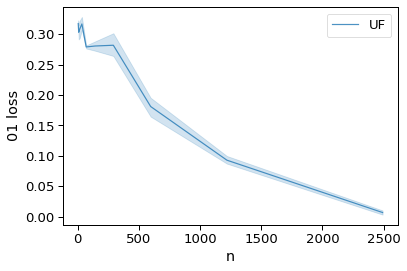

In [44]:
df = pd.DataFrame(
    scores, columns=results_dict['sample_sizes']
).melt(
    var_name='n',
    value_name='01 loss',
)
sns.lineplot(
    data=df, x='n', y='01 loss', label='UF', legend=True, alpha=0.8)

In [9]:
# def get_task_scores(score_fn, results_dir, fold_mean=True):
#     tasks = []
#     fold_scores = []
#     task_score_means = []
#     task_score_stds = []
#     for file in os.listdir(results_dir)[::-1]:
#         with open(results_dir + file, 'rb') as f:
#             results_dict = pickle.load(f)
#         fold_scores = [
#             [
#                 score_fn(
#                     results_dict['y'][idx], y_proba
#                 ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
#             ] for name in clfs
#         ]
        
#         if fold_mean:
#             score_means = [np.mean(scores) for scores in fold_scores]
#             score_stds = [np.std(scores) for scores in fold_scores]
#             task_score_means.append(score_means)
#             task_score_stds.append(score_stds)
#         else:
#             fold_scores.append(fold_scores)

#         tasks.append(
#             {k: results_dict[k] for k in ['task_id', 'task', 'n_samples', 'n_classes', 'n_features']
#             })
        
#     if fold_mean:
#         return tasks, task_score_means, task_score_stds
#     else:
#         return tasks, fold_scores

def get_task_scores(score_fn, results_dir):
    tasks = []
    fold_scores = []
    # task_score_means = []
    # task_score_stds = []
    for file in os.listdir(results_dir)[::-1]:
        with open(results_dir + file, 'rb') as f:
            results_dict = pickle.load(f)
        # score_means = [
        #     np.mean([
        #         score_fn(
        #             results_dict['y'][idx], y_proba
        #         ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
        #     ]) for name in clfs
        # ]

        # score_stds = [
        #     np.std([
        #         score_fn(
        #             results_dict['y'][idx], y_proba
        #         ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
        #     ]) for name in clfs
        # ]

        scores = np.asarray([
            [
                score_fn(
                    results_dict['y'][idx], y_proba
                ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])
            ] for name in clfs
        ])

        tasks.append(
            {k: results_dict[k] for k in ['task_id', 'task', 'n_samples', 'n_classes', 'n_features']
             })
        # task_score_means.append(score_means)
        # task_score_stds.append(score_stds)
        fold_scores.append(scores)

    # return tasks, task_score_means, task_score_stds
    return tasks, fold_scores

## CSVs

### Brier

In [10]:
# tasks, task_score_means, task_score_stds = get_task_scores(brier_score_mvloss, results_dir)
tasks, task_scores = get_task_scores(brier_score_mvloss, results_dir)

df_rows = []
# for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
#     row = [f'{m:.3f} ({s:.3f})' for m, s in zip(score_means, score_stds)]
for task, scores in zip(tasks, task_scores):
    row = [f'{np.mean(s):.3f} ({np.std(s):.3f})' for s in scores]
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + row
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [11]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

In [15]:
task_scores = np.asarray(task_scores)

In [31]:
(task_scores[:, 1] - task_scores[:, -1]).mean(-1)

array([-3.39785038e-03, -6.47249532e-03,  7.99114280e-05,  4.79654914e-03,
       -6.28496237e-03, -4.42980934e-03, -8.89796708e-03, -1.77766127e-02,
       -6.60139278e-03, -3.07919293e-03, -1.85602003e-03])

In [8]:
score_df.to_csv(f'./figures/{tag}/brier_scores_cv10.csv')

### ECE

In [9]:
tasks, task_score_means, task_score_stds = get_task_scores(ece, results_dir)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = [f'{m:.3f} ({s:.3f})' for m, s in zip(score_means, score_stds)]
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + row
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [10]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

In [12]:
score_df.to_csv(f'./figures/{tag}/ece_scores_cv10.csv')

### MCE

In [13]:
tasks, task_score_means, task_score_stds = get_task_scores(mce, results_dir)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = [f'{m:.3f} ({s:.3f})' for m, s in zip(score_means, score_stds)]
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + row
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

In [14]:
score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

In [15]:
score_df.to_csv(f'./figures/{tag}/mce_scores_cv10.csv')

# Plots

In [125]:
def continuous_pairplot(df, vars, hue, cmap, diag_kind, scale='log'):
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    vmin = min(np.min([df[hue]]), -1e-6)
    vmax = max(np.max([df[hue]]), 1e-6)
    g = sns.pairplot(
        df,
        vars=vars,
        diag_kind=diag_kind,
        plot_kws=dict(
            # The effort I put into figuring this out.....
            c=df[hue], cmap=cmap, norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)
        ),
    )
    if scale:
        for r in range(len(g.axes)):
            for c in range(len(g.axes)):
                g.axes[r , c].set_xscale(scale)
                if r != c:
                    g.axes[c , r].set_yscale(scale)
    
    sm = mpl.cm.ScalarMappable(
        mpl.colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax),
        cmap=cmap
    )
    plt.colorbar(sm, ax=g.axes, label=hue, aspect=40)
    return g

## Brier Score

In [126]:
tasks, task_score_means, task_score_stds = get_task_scores(brier_score_mvloss, results_dir)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = np.round(score_means, 5)
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + list(row)
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

for col in ['RF', 'IRF', 'SigRF']:
    score_df[f'{col}-UF'] = score_df.apply(
        lambda row: (row[col] - row['UF']), axis=1)
    
score_df['UF_diff_max'] = score_df.apply(
    lambda row: max([row[f'{col}-UF'] for col in ['RF', 'IRF', 'SigRF']]), axis=1)

## Testing for performance boost

In [84]:
from collections import defaultdict
from scipy.stats import spearmanr

In [85]:
df = score_df.sort_values('RF-UF', ascending=False)[['Dataset', 'n_classes', 'n_features', 'RF', 'UF', 'RF-UF']]

In [86]:
task_ids = np.asarray(df.index)
target_vals = defaultdict(list)

dataset_attrs = defaultdict(list)
for task_id in task_ids:
    task = openml.tasks.get_task(task_id)
    for key, val in task.get_dataset().qualities.items():
        dataset_attrs[key].append(val)
        target_vals[key].append(df.loc[task_id]['RF-UF'])

In [87]:
target = df
corrs = []
attrs = []
pvals = []
for key, val in dataset_attrs.items():
    val = np.asarray(val)
    if any(np.isnan(val)):
        continue
    else:
        corr, pval = spearmanr(val, target_vals[key])
        corrs.append(corr)
        attrs.append(key)
        pvals.append(pval)

In [26]:
stats_corr_df = pd.DataFrame(data=np.asarray([attrs, corrs, pvals]).T, columns=['Dataset_attribute', 'spearmanr', 'pvalue'])

In [31]:
with pd.option_context("display.max_rows", 1000):
    display(stats_corr_df.sort_values(by='pvalue'))

,Dataset_attribute,spearmanr,pvalue
12,DecisionStumpErrRate,-0.5146342050512193,0.0001315479179550813
24,MajorityClassPercentage,0.46489686579828,0.00030639779153262685
10,ClassEntropy,-0.4640079616571743,0.0003157583130108453
42,PercentageOfBinaryFeatures,0.42336751688769697,0.0011495934602095263
66,kNN1NAUC,-0.4391356542617047,0.0014208260554886749
68,kNN1NKappa,-0.4148379351740696,0.0027408451035715663
33,NaiveBayesKappa,-0.3987995198079231,0.004121951899400467
34,NumberOfBinaryFeatures,0.3742661412363201,0.004488009621458121
31,NaiveBayesAUC,-0.38727490996398556,0.005460748701091597
35,NumberOfClasses,-0.34289420687075334,0.00967981555120363


In [110]:
m = len(clfs)
stat_mat = []
for r in range(m):
    stat_mat.append([])
    for c in range(m):
        if r == c:
            stat_mat[r].append('')
            continue
        # Wilcoxon(x, y) significant if x < y
        stat, pval = wilcoxon(score_df[clfs[r]], score_df[clfs[c]], zero_method='zsplit', alternative='less')
        stat_mat[r].append(f'{stat:.3f} ({pval:.3f})')
        
stat_mat = pd.DataFrame(stat_mat, columns = clfs)
stat_mat.index = clfs
stat_mat.to_csv(f'./figures/{tag}/brier_wilcoxon_cv10.csv')
display(stat_mat)

,RF,IRF,SigRF,UF
RF,,74.000 (0.997),78.000 (0.999),40.000 (0.531)
IRF,4.000 (0.003),,17.000 (0.042),8.000 (0.008)
SigRF,0.000 (0.001),61.000 (0.958),,17.000 (0.042)
UF,38.000 (0.469),70.000 (0.992),61.000 (0.958),


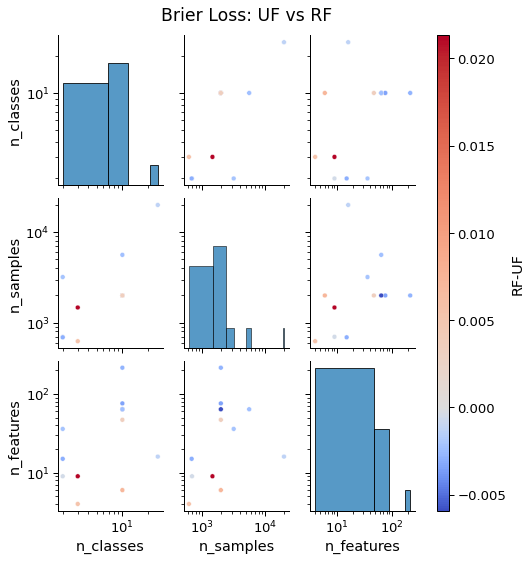

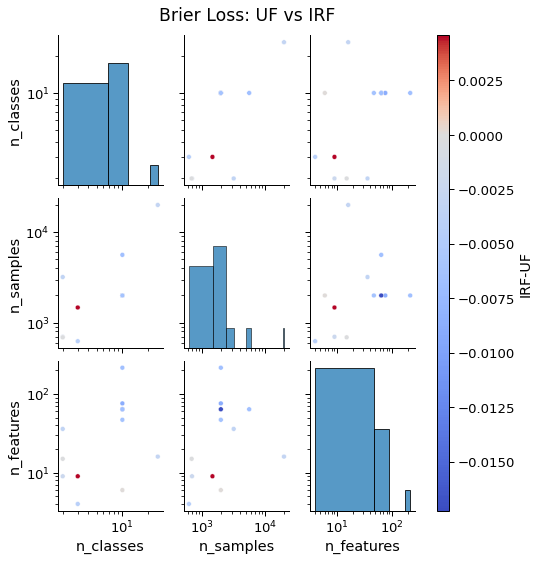

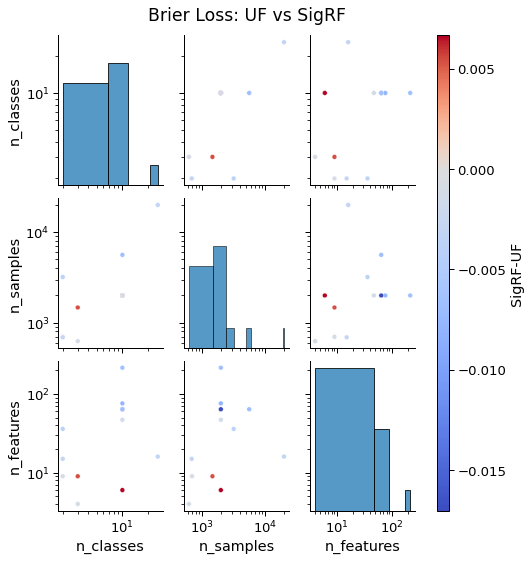

In [127]:
for clf in ['RF', 'IRF', 'SigRF']:
    g = continuous_pairplot(
        score_df,
        vars=['n_classes', 'n_samples', 'n_features'],
        hue=f'{clf}-UF',
        cmap='coolwarm',
        diag_kind='hist',
    )
    g.fig.suptitle(f'Brier Loss: UF vs {clf}', y=1.03)
    plt.savefig(f'./figures/{tag}/brier_pairplot_UF-vs-{clf}.pdf')
    plt.show()

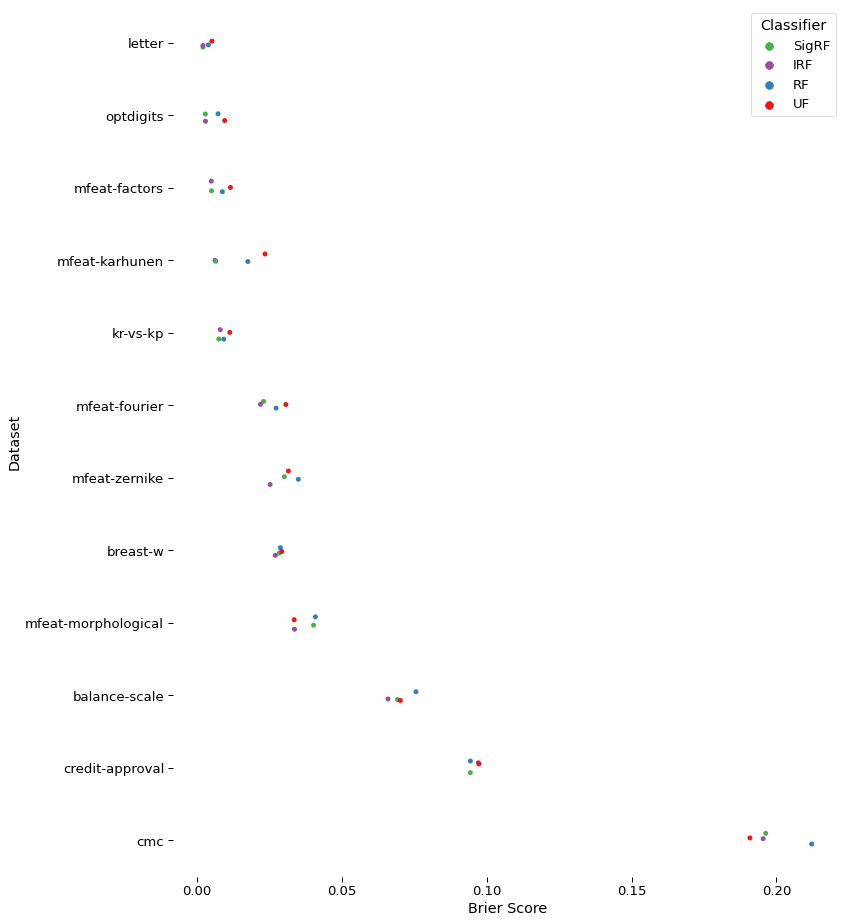

In [112]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset'] + clfs]
df = df.melt(
    id_vars=['Dataset'], value_vars=clfs, var_name='Classifier', value_name='Brier Score'
).sort_values('Brier Score')

# Show each observation with a scatterplot
sns.stripplot(x="Brier Score", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)

plt.savefig(f'./figures/{tag}/brier_scatterplot.pdf')
plt.show()

## ECE Plots

In [128]:
tasks, task_score_means, task_score_stds = get_task_scores(ece, results_dir)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = np.round(score_means, 5)
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + list(row)
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

for col in ['RF', 'IRF', 'SigRF']:
    score_df[f'{col}-UF'] = score_df.apply(
        lambda row: (row[col] - row['UF']), axis=1)
    
score_df['UF_diff_max'] = score_df.apply(
    lambda row: max([row[f'{col}-UF'] for col in ['RF', 'IRF', 'SigRF']]), axis=1)

In [114]:
m = len(clfs)
stat_mat = []
for r in range(m):
    stat_mat.append([])
    for c in range(m):
        if r == c:
            stat_mat[r].append('')
            continue
        # Wilcoxon(x, y) significant if x < y
        stat, pval = wilcoxon(score_df[clfs[r]], score_df[clfs[c]], zero_method='zsplit', alternative='less')
        stat_mat[r].append(f'{stat:.3f} ({pval:.3f})')
        
stat_mat = pd.DataFrame(stat_mat, columns = clfs)
stat_mat.index = clfs
stat_mat.to_csv(f'./figures/{tag}/ece_wilcoxon_cv10.csv')
display(stat_mat)

,RF,IRF,SigRF,UF
RF,,74.000 (0.997),63.000 (0.970),19.000 (0.058)
IRF,4.000 (0.003),,0.000 (0.001),0.000 (0.001)
SigRF,15.000 (0.030),78.000 (0.999),,12.000 (0.017)
UF,59.000 (0.942),78.000 (0.999),66.000 (0.983),


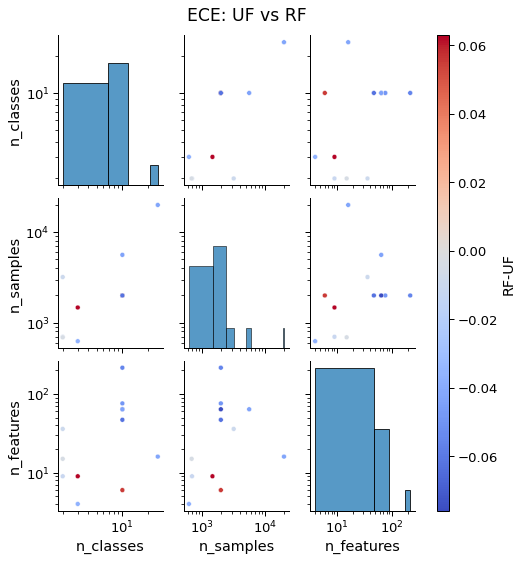

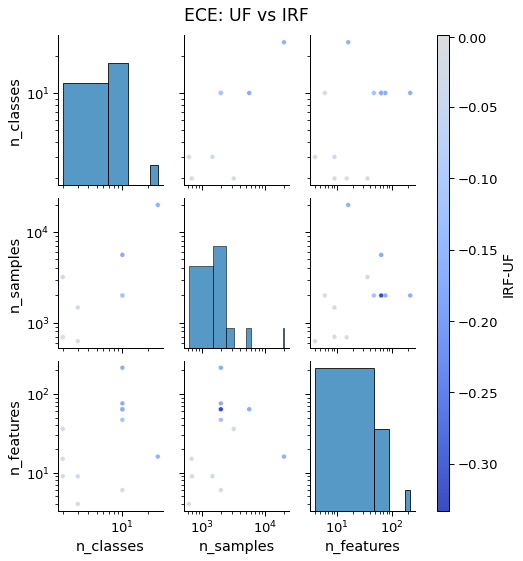

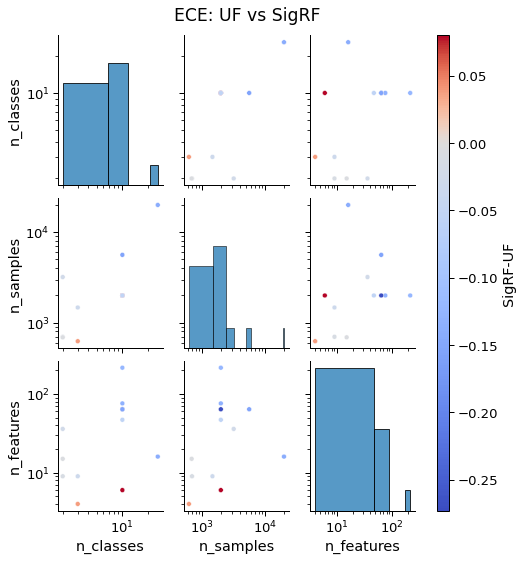

In [129]:
for clf in ['RF', 'IRF', 'SigRF']:
    g = continuous_pairplot(
        score_df,
        vars=['n_classes', 'n_samples', 'n_features'],
        hue=f'{clf}-UF',
        cmap='coolwarm',
        diag_kind='hist',
    )
    g.fig.suptitle(f'ECE: UF vs {clf}', y=1.03)
    plt.savefig(f'./figures/{tag}/ece_pairplot_UF-vs-{clf}.pdf')
    plt.show()

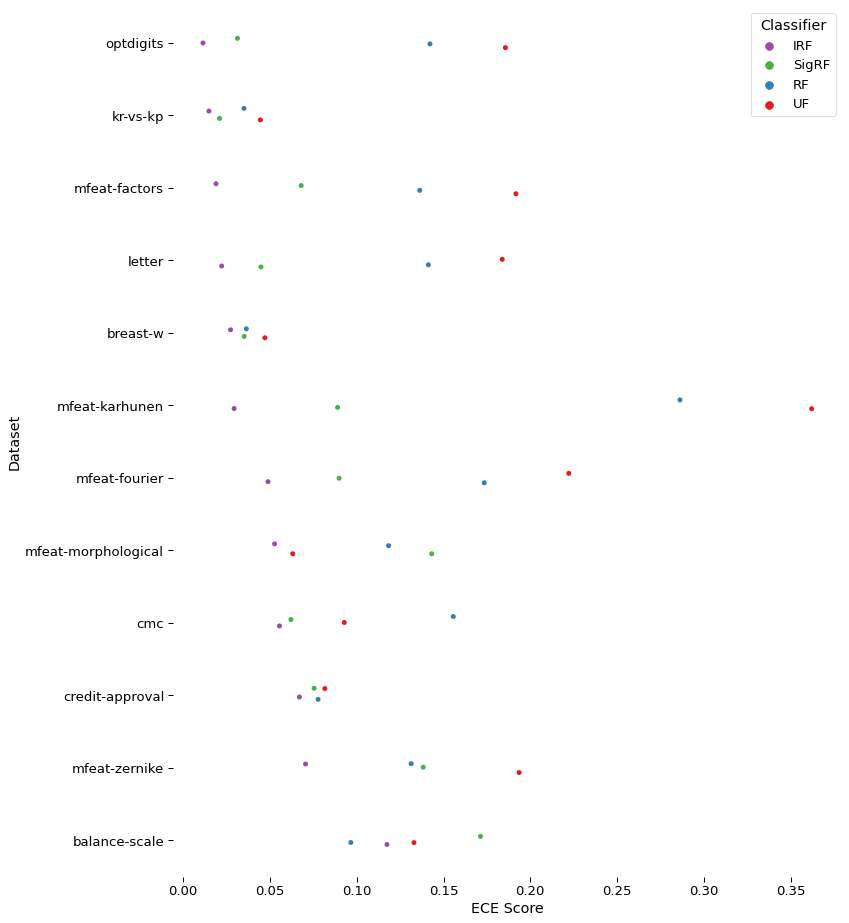

In [116]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset'] + clfs]
df = df.melt(
    id_vars=['Dataset'], value_vars=clfs, var_name='Classifier', value_name='ECE Score'
).sort_values('ECE Score')

# Show each observation with a scatterplot
sns.stripplot(x="ECE Score", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)

plt.savefig(f'./figures/{tag}/ece_scatterplot.pdf')
plt.show()

## MCE Plots

In [130]:
tasks, task_score_means, task_score_stds = get_task_scores(mce, results_dir)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = np.round(score_means, 5)
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + list(row)
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

for col in ['RF', 'IRF', 'SigRF']:
    score_df[f'{col}-UF'] = score_df.apply(
        lambda row: (row[col] - row['UF']), axis=1)
    
score_df['UF_diff_max'] = score_df.apply(
    lambda row: max([row[f'{col}-UF'] for col in ['RF', 'IRF', 'SigRF']]), axis=1)

In [118]:
m = len(clfs)
stat_mat = []
for r in range(m):
    stat_mat.append([])
    for c in range(m):
        if r == c:
            stat_mat[r].append('')
            continue
        # Wilcoxon(x, y) significant if x < y
        stat, pval = wilcoxon(score_df[clfs[r]], score_df[clfs[c]], zero_method='zsplit', alternative='less')
        stat_mat[r].append(f'{stat:.3f} ({pval:.3f})')
        
stat_mat = pd.DataFrame(stat_mat, columns = clfs)
stat_mat.index = clfs
stat_mat.to_csv(f'./figures/{tag}/mce_wilcoxon_cv10.csv')
display(stat_mat)

,RF,IRF,SigRF,UF
RF,,63.000 (0.970),56.000 (0.909),43.000 (0.623)
IRF,15.000 (0.030),,26.000 (0.154),20.000 (0.068)
SigRF,22.000 (0.091),52.000 (0.846),,28.000 (0.194)
UF,35.000 (0.377),58.000 (0.932),50.000 (0.806),


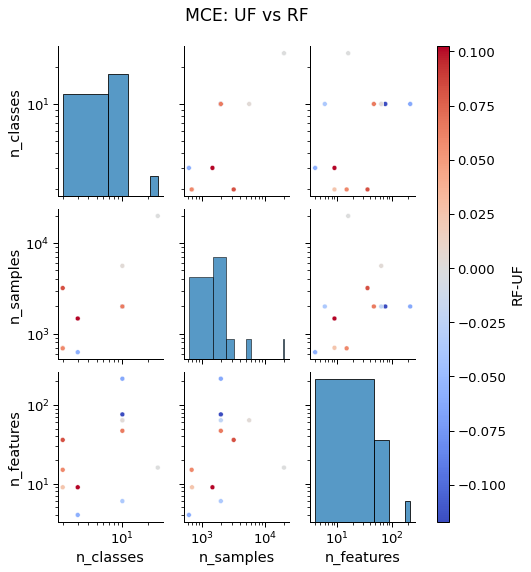

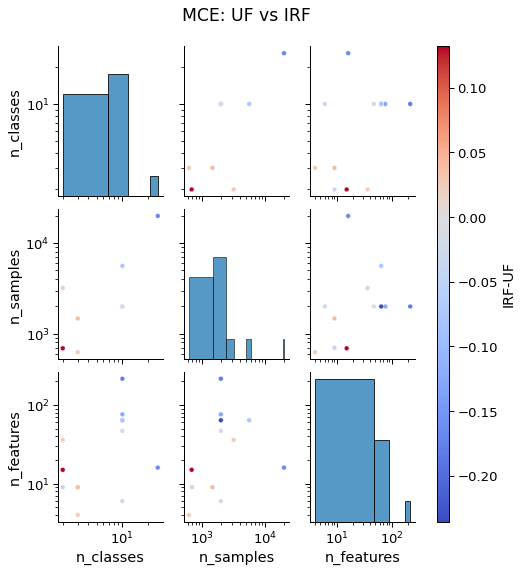

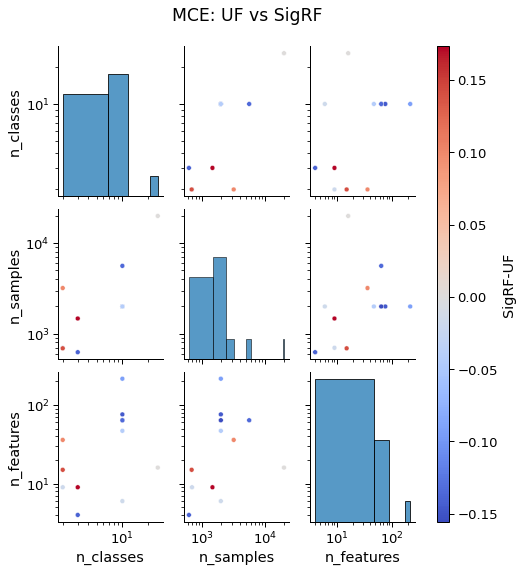

In [131]:
for clf in ['RF', 'IRF', 'SigRF']:
    g = continuous_pairplot(
        score_df,
        vars=['n_classes', 'n_samples', 'n_features'],
        hue=f'{clf}-UF',
        cmap='coolwarm',
        diag_kind='hist',
    )
    g.fig.suptitle(f'MCE: UF vs {clf}', y=1.05)
    plt.savefig(f'./figures/{tag}/mce_pairplot_UF-vs-{clf}.pdf')
    plt.show()

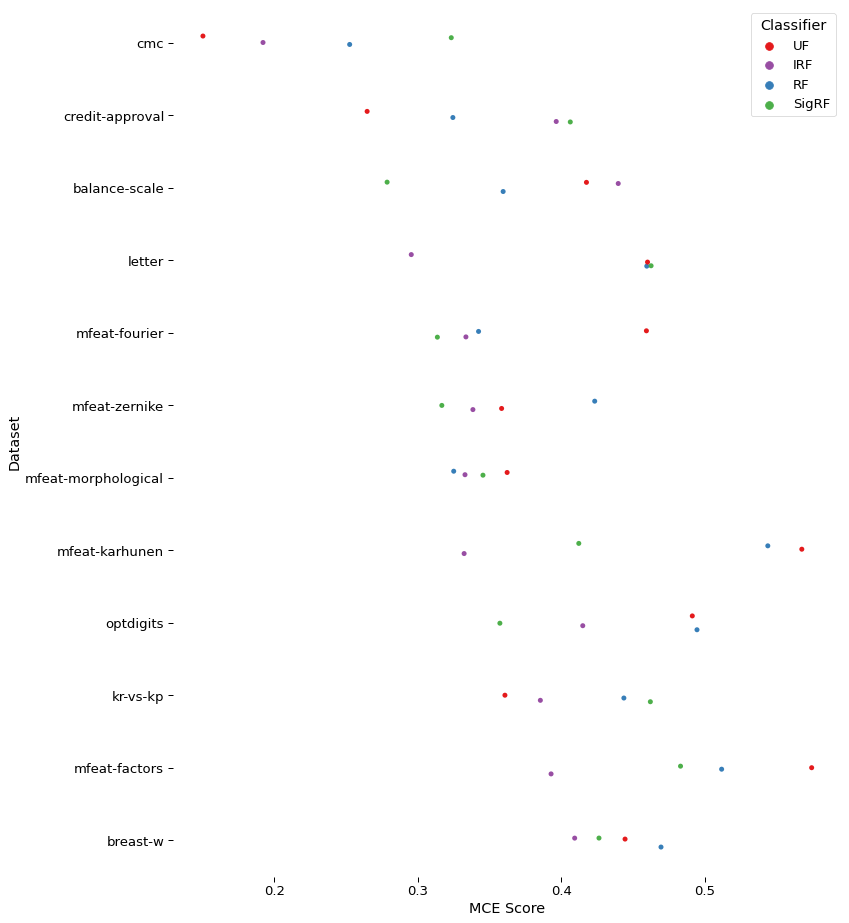

In [120]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset'] + clfs]
df = df.melt(
    id_vars=['Dataset'], value_vars=clfs, var_name='Classifier', value_name='MCE Score'
).sort_values('MCE Score')

# Show each observation with a scatterplot
sns.stripplot(x="MCE Score", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)
plt.savefig(f'./figures/{tag}/mce_scatterplot.pdf')
plt.show()

## Error

In [132]:
tasks, task_score_means, task_score_stds = get_task_scores(
    lambda y_true, y_proba: zero_one_loss(y_true, y_proba.argmax(1)), results_dir)

df_rows = []
for task, score_means, score_stds in zip(tasks, task_score_means, task_score_stds):
    row = np.round(score_means, 5)
    row = [task['task'], task['n_classes'], task['n_samples'], task['n_features']] + list(row)
    df_rows.append(row)
header = ['Dataset', 'n_classes', 'n_samples', 'n_features'] + clfs

score_df = pd.DataFrame(
    df_rows, columns=header, index=[task['task_id'] for task in tasks]
).sort_index()

for col in ['RF', 'IRF', 'SigRF']:
    score_df[f'{col}-UF'] = score_df.apply(
        lambda row: (row[col] - row['UF']), axis=1)
    
score_df['UF_diff_max'] = score_df.apply(
    lambda row: max([row[f'{col}-UF'] for col in ['RF', 'IRF', 'SigRF']]), axis=1)

In [122]:
m = len(clfs)
stat_mat = []
for r in range(m):
    stat_mat.append([])
    for c in range(m):
        if r == c:
            stat_mat[r].append('')
            continue
        # Wilcoxon(x, y) significant if x < y
        stat, pval = wilcoxon(score_df[clfs[r]], score_df[clfs[c]], zero_method='zsplit', alternative='less')
        stat_mat[r].append(f'{stat:.3f} ({pval:.3f})')
        
stat_mat = pd.DataFrame(stat_mat, columns = clfs)
stat_mat.index = clfs
stat_mat.to_csv(f'./figures/{tag}/error_wilcoxon_cv10.csv')
display(stat_mat)

,RF,IRF,SigRF,UF
RF,,35.000 (0.377),15.000 (0.030),36.500 (0.422)
IRF,43.000 (0.623),,42.500 (0.608),23.000 (0.105)
SigRF,63.000 (0.970),35.500 (0.392),,31.000 (0.265)
UF,41.500 (0.578),55.000 (0.895),47.000 (0.735),


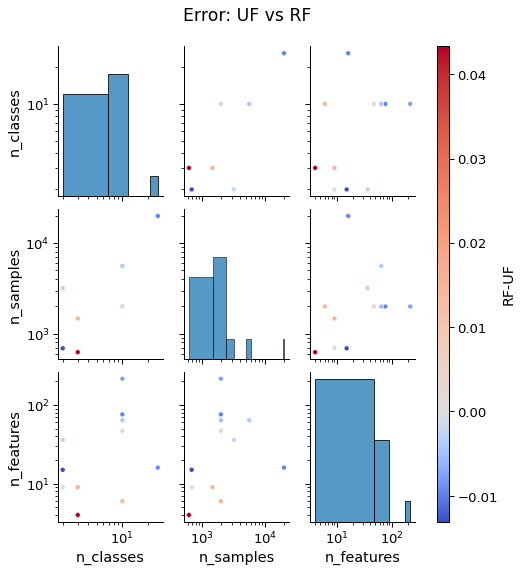

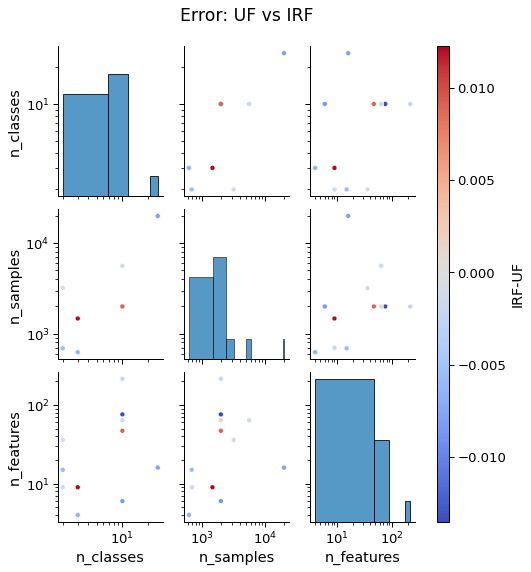

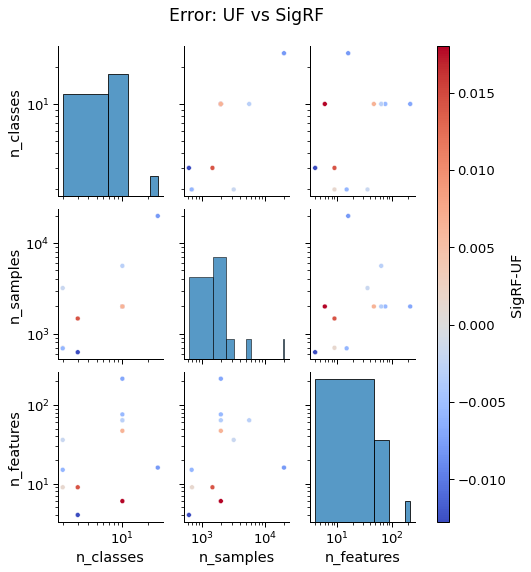

In [133]:
for clf in ['RF', 'IRF', 'SigRF']:
    g = continuous_pairplot(
        score_df,
        vars=['n_classes', 'n_samples', 'n_features'],
        hue=f'{clf}-UF',
        cmap='coolwarm',
        diag_kind='hist',
    )
    g.fig.suptitle(f'Error: UF vs {clf}', y=1.05)
    plt.savefig(f'./figures/{tag}/error_pairplot_UF-vs-{clf}.pdf')
    plt.show()

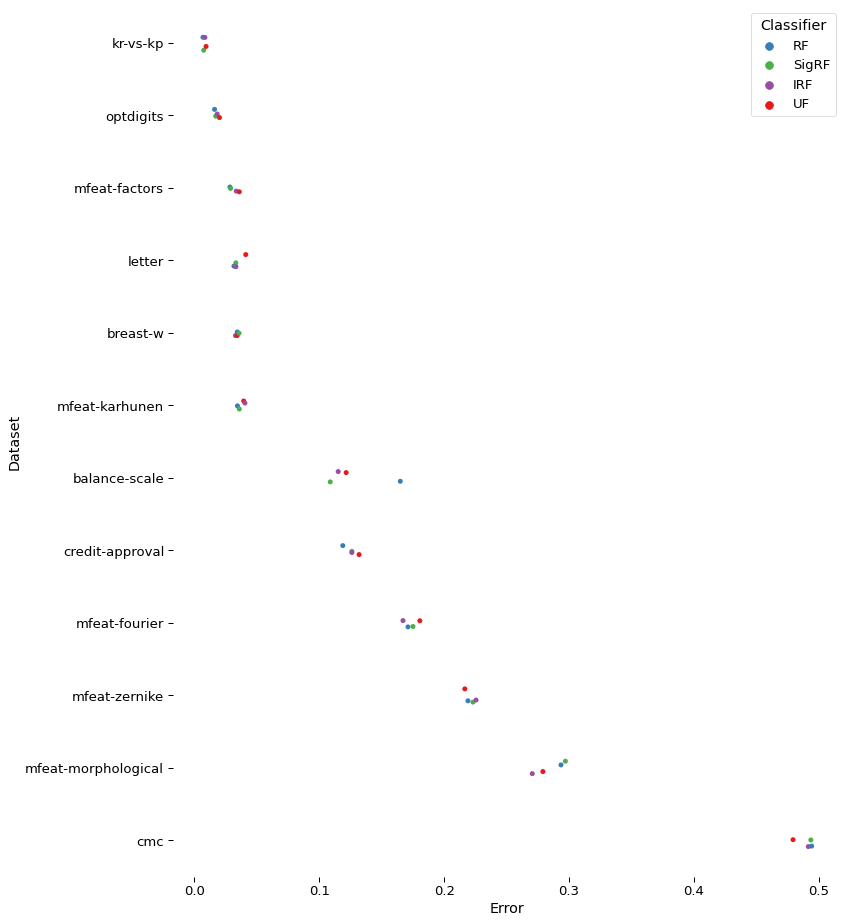

In [124]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12,16))
sns.despine(bottom=True, left=True)

df = score_df[['Dataset'] + clfs]
df = df.melt(
    id_vars=['Dataset'], value_vars=clfs, var_name='Classifier', value_name='Error'
).sort_values('Error')

# Show each observation with a scatterplot
sns.stripplot(x="Error", y="Dataset", hue="Classifier",
              data=df, dodge=False, alpha=1, zorder=1, palette=color_dict)
plt.savefig(f'./figures/{tag}/error_scatterplot.pdf')
plt.show()